
## Before running

This is the code for making the "Masking image" of FITS file for images taken by the Andalucia Faint Object Spectrograph
and Camera (ALFOSC) with the FAPOL polarimeter <br>on the 2.56-m Nordic Optical Telescope at the Observatorio del Roque de los
Muchachos, La Palma.<br><br>
    

The "Masking image" masks the 1) nearby stars and 2) Cosmic ray.
1. 
 * Input file:  
     * '*.fits'         Preprocessed FITS file
    * '*.mag.1'       IRAF Phot file containing target's center info.<br> 
         &nbsp;See below (i.e.,2. What you need to run this code)
 
 * Output file:
     * 'mask_*.fits'      Masking image in FITS format
<br><br><br>
2. What you need to run this code. The following packages must be installed.
  * astropy (https://www.astropy.org/)
  * Astro-SCRAPPY (https://github.com/astropy/astroscrappy)
  * ``*.mag.1`` file from IRAF's Phot package that contains the center of target's o-ray compnent.
<br><br><br>  
3. In this code, the center of the target is found by using the phot of IRAF. So, we need the ``.mag`` file to bring the coordinate of target's ceter.<br>
There is no problem if you find the target's center by other methods. All you need to do is modifying the part that brings the central coordinate of target. <br>
See ``Bring the x,y information of object from .mag.1`` part.
<br><br><br>    
4. Directory should contain the complete sets consist of 4 images (taken at HWP=0+90*n, 22.5+90*n, 45+90*n, 67.5+90n deg where n=0,1,2,3).<br> 
If the number of images in the directory is not a multiple of 4, an error occurs.

<br><br><br>    



### Import packages and define the function

In [9]:
import glob 
import os
import astropy
import astroquery
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
import astroscrappy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from astroquery.jplhorizons import Horizons
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import warnings
from astropy.utils.exceptions import AstropyWarning
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
from tqdm import tqdm


def pill_masking(image,x1,x2,y1,y2,height_mag,target_x,target_y,target_radi=8):
    
    figsize = 140
    
    y_str = int(round(target_y - figsize))
    y_end = int(round(target_y + figsize))
    x_str = int(round(target_x - figsize))
    x_end = int(round(target_x  + figsize))

    
    x_star_str = x1 - x_str 
    x_star_end = x2 - x_str 
    y_star_str = y1 - y_str 
    y_star_end = y2 - y_str 
    
    target_x_ = figsize
    target_y_ = figsize
    
    cropp_image = image[y_str:y_end, x_str:x_end] 
    

    Masking_image = np.zeros(np.shape(image))
    Masking_crop = Masking_image[y_str:y_end, x_str:x_end] 
    
    for yi in range(len(Masking_crop)):
        for xi in range(len(Masking_crop)):
            for star in range(len(x_star_end)):
                width  = 13 #The width of the masking area is chosen by a rule of thumb
                if height_mag[star] < 16:
                    height = width/2 * 4
                elif 16 < height_mag[star] < 18:
                    height = width/2*3
                elif 18 < height_mag[star] <19 :
                    height = width/2*2
                elif 19 < height_mag[star] :
                    height = width/2*2
                    
                     
                slope = (y_star_end[star] - y_star_str[star])/(x_star_end[star]-x_star_str[star])
                y_up = slope *xi + y_star_str[star] + height - slope *x_star_str[star]
                y_low = slope *xi + y_star_str[star] - height - slope *x_star_str[star]
                x_str_ = min(x_star_str[star],x_star_end[star])
                x_end_ = max(x_star_str[star],x_star_end[star])

                if (xi - x_star_str[star])**2 + (yi-y_star_str[star])**2 < (height)**2:
                    Masking_crop[yi,xi] = 3
                if (xi - x_star_end[star])**2 + (yi-y_star_end[star])**2 < (height)**2:
                    Masking_crop[yi,xi] = 3    
                if yi >= y_low and  y_up >= yi and xi > x_str_ and x_end_ > xi:
                    Masking_crop[yi,xi] = 3   
                    
    Masking_image[y_str:y_end, x_str:x_end]=Masking_crop             
    return Masking_image    
    

mpl.rc('figure', max_open_warning = 0)
np.set_printoptions(threshold=1000)
pd.set_option('display.max_rows', None)
warnings.simplefilter('ignore', category=AstropyWarning)
print('Version----------')
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('astropy',astropy.__version__)
print('astroscrappy',astroscrappy.__version__)
print('astroquery',astroquery.__version__)

Version----------
pandas 1.0.1
numpy 1.20.3
astropy 4.0
astroscrappy 1.0.8
astroquery 0.4.7.dev7761


### Bring the target image to be masked

In [10]:
path = os.path.join('/home','judy','Downloads/P64_phaethon_polarimetry','211112','target','reduced') #Where your image data are saved
filelist = glob.glob(os.path.join(path,'A*P*.fits'))
filelist = sorted(filelist)

log = pd.DataFrame({})
for fi in filelist:
    hdul = fits.open(fi)
    header = hdul[0].header
    data = hdul[0].data
    log = log.append({'FILENAME':os.path.split(fi)[-1],
                      'OBJECT':header['OBJECT'],
                      'IMAGETYP':header['IMAGETYP'],
                      'IMAGECAT':header['IMAGECAT'],
                      'FARETANG':header['FARETANG'],
                      'INSTRUME':header['CHIPID'],
                      'EXPTIME':header['EXPTIME'],
                      'SIZE':np.shape(data)},
                      ignore_index=True)
log        

,EXPTIME,FARETANG,FILENAME,IMAGECAT,IMAGETYP,INSTRUME,OBJECT,SIZE
0,180.0,270.0,ALEk120276.Phaethon.270.0.fits,SCIENCE,OBJECT,12234-10-01,Phaethon 270deg,"(750, 750)"
1,180.0,292.5,ALEk120277.Phaethon.292.5.fits,SCIENCE,OBJECT,12234-10-01,Phaethon 292.5deg,"(750, 750)"
2,180.0,315.0,ALEk120278.Phaethon.315.0.fits,SCIENCE,OBJECT,12234-10-01,Phaethon 315deg,"(750, 750)"
3,180.0,337.5,ALEk120279.Phaethon.337.5.fits,SCIENCE,OBJECT,12234-10-01,Phaethon 337.5deg,"(750, 750)"
4,180.0,0.0,ALEk120280.Phaethon.0.0.fits,SCIENCE,OBJECT,12234-10-01,Phaethon 0deg,"(750, 750)"
5,180.0,22.5,ALEk120281.Phaethon.22.5.fits,SCIENCE,OBJECT,12234-10-01,Phaethon 22.5deg,"(750, 750)"
6,180.0,45.0,ALEk120282.Phaethon.45.0.fits,SCIENCE,OBJECT,12234-10-01,Phaethon 45deg,"(750, 750)"
7,180.0,67.5,ALEk120283.Phaethon.67.5.fits,SCIENCE,OBJECT,12234-10-01,Phaethon 67.5deg,"(750, 750)"


### Make and save the masking image




  0%|          | 0/2 [00:00<?, ?it/s]

INFO: Query finished. [astroquery.utils.tap.core]


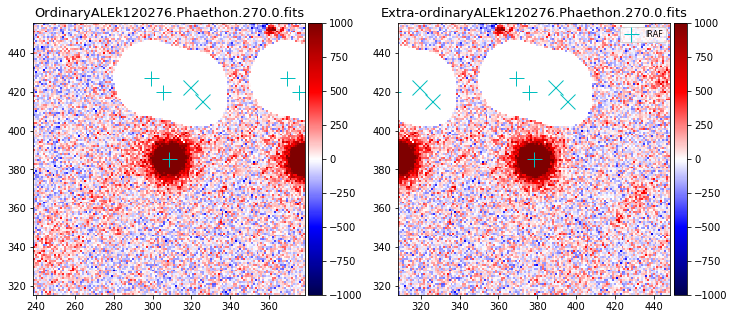

INFO: Query finished. [astroquery.utils.tap.core]


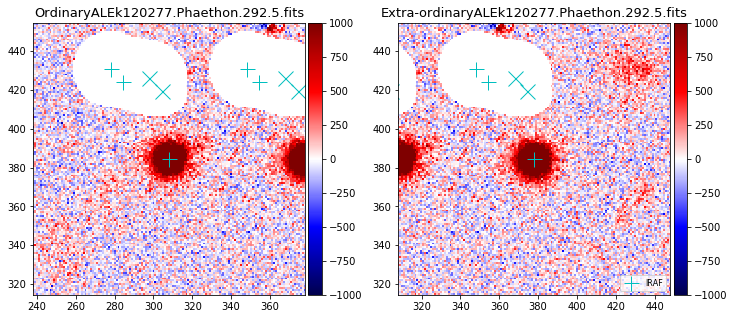

INFO: Query finished. [astroquery.utils.tap.core]


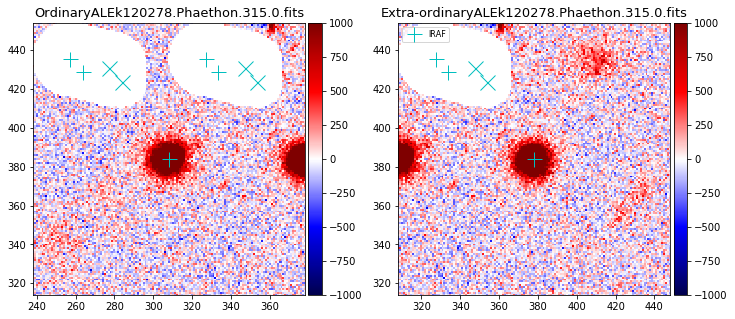

INFO: Query finished. [astroquery.utils.tap.core]


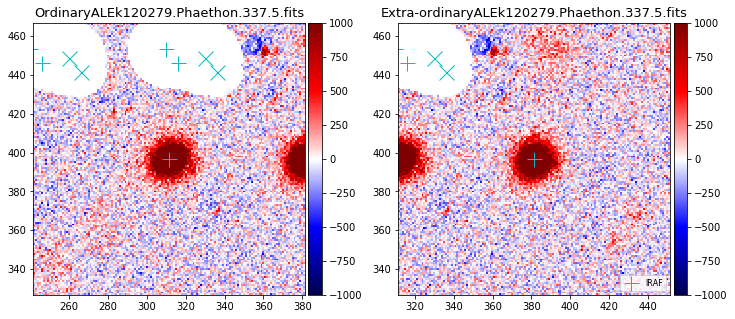



 50%|█████     | 1/2 [01:34<01:34, 94.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


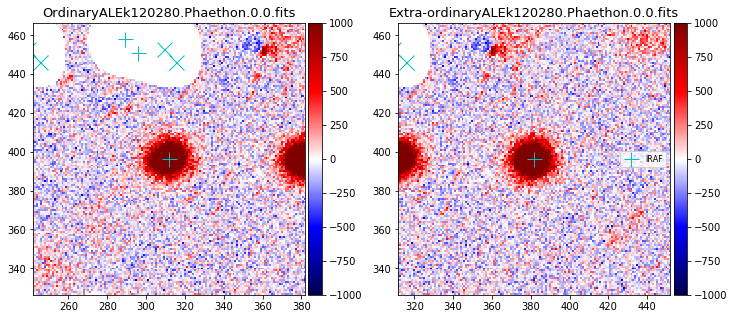

INFO: Query finished. [astroquery.utils.tap.core]


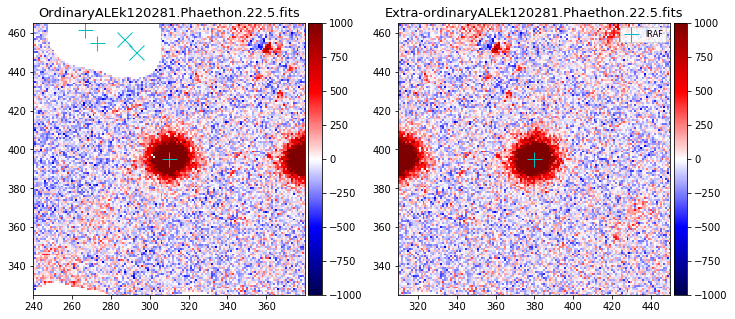

INFO: Query finished. [astroquery.utils.tap.core]


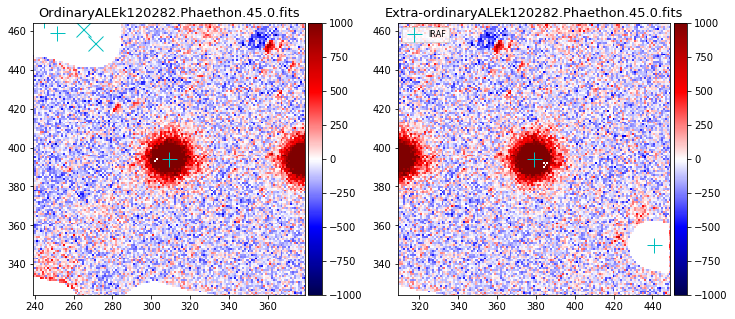

INFO: Query finished. [astroquery.utils.tap.core]


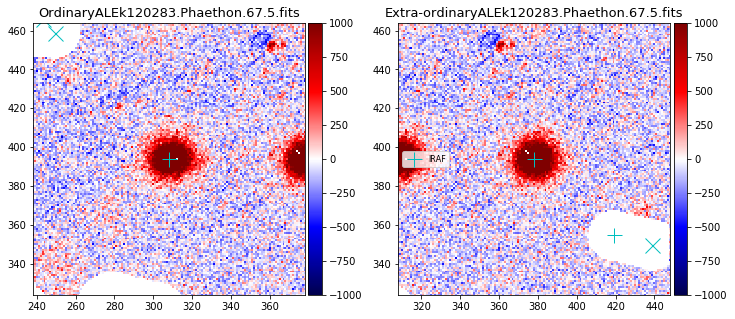



100%|██████████| 2/2 [03:19<00:00, 99.57s/it]


In [13]:
#Making the Masking image and plot the masked image

order = np.arange(0,len(filelist),4)
for z in tqdm(order):
    SET = [filelist[z],filelist[z+1], filelist[z+2], filelist[z+3]]
    for i in range(0,4):
        RET = SET[i]  #Bring the fits file
        maskfilename = os.path.join(path,'mask_'+os.path.split(RET)[-1])
        hdul = fits.open(RET)[0]
        header1 = hdul.header 
        image = hdul.data
        OBJECT = header1['OBJECT']
        JD = Time(header1['DATE-OBS'],format='isot').jd
        exptime = header1['EXPTIME'] #in sec    
        EXPTIME = header1['EXPTIME'] / (24*60*60)  #in jd
        EXP_str = Time(header1['DATE-OBS'],format='isot').jd
        EXP_end = EXP_str + EXPTIME
        
        
        RET1 = os.path.join(path,RET.split('/')[-1])
       
        #Bring the x,y information of object from .mag.1 =
        mag = ascii.read(RET1+'.mag.1')
        xo = mag['XCENTER'][0] - 1
        yo = mag['YCENTER'][0] - 1
    
        xe = xo+70
        ye = yo
        
        #===============================================
        
        
        y_str = int(round(yo - 70))
        y_end = int(round(yo + 70))
        x_str = int(round(xo - 70))
        x_end = int(round(xo  + 70))
        cropp_image = image[y_str:y_end, x_str:x_end] 
        
        
        try:
            header1['GAIN']
        except KeyError:
            print('There is no GAIN in header. Using gain 0.16 & RN = 4.3')
            gain = 0.16
            RN = 4.3
        else:
            gain = header1['GAIN']
            RN = header1['RDNOISE']

        m_LA,cor_image = astroscrappy.detect_cosmics(image,
                                                      gain = gain,
                                                      readnoise = RN,
                                                       sigclip=3)
        tmLA = m_LA.astype(int)


        #MAKE THE MASKED IMAGE
        MASK = np.zeros(np.shape(image))
        MASK[tmLA == 1 ] = 1


        #Find the nearby star
        obj = Horizons(id=3200,location='Z23', epochs=EXP_str)
        eph = obj.ephemerides()
        ra,dec = eph['RA'][0], eph['DEC'][0]
        header1['CRPIX1'], header1['CRPIX2'] = xo,yo
        header1['CRVAL1'], header1['CRVAL2'] = ra,dec
        #Bring WCS info
        w =WCS(header1)
        coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
        width = u.Quantity(0.025, u.deg)
        height = u.Quantity(0.025, u.deg)
        r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

        RA_star = []
        DEC_star = []
        g_star = []
        for i in range(len(r)):
            if r[i]['phot_g_mean_mag'] < 23:
                RA_star.append(r[i]['ra'])
                DEC_star.append(r[i]['dec'])
                g_star.append(r[i]['phot_g_mean_mag'])
            elif r[i]['phot_g_mean_mag'] > 23:
                header['Warning'] = 'Backgroud star > 23 mag'
        x_star_str, y_star_str = w.wcs_world2pix(RA_star,DEC_star,0)

        header1['CRPIX1'], header1['CRPIX2'] = xe,ye
        w =WCS(header1)
        x_star_str_e, y_star_str_e = w.wcs_world2pix(RA_star,DEC_star,0)
        
        
        
        
        
        obj = Horizons(id=3200,location='Z23', epochs=EXP_end)
        eph = obj.ephemerides()
        ra,dec = eph['RA'][0], eph['DEC'][0]

        header1['CRPIX1'], header1['CRPIX2'] = xo,yo
        header1['CRVAL1'], header1['CRVAL2'] = ra,dec
        #Bring WCS info
        w =WCS(header1)
        x_star_end, y_star_end = w.wcs_world2pix(RA_star,DEC_star,0)
        header1['CRPIX1'], header1['CRPIX2'] = xe,ye
        w =WCS(header1)
        x_star_end_e, y_star_end_e = w.wcs_world2pix(RA_star,DEC_star,0)
        Masking_image_o = pill_masking(data,x_star_str,x_star_end,y_star_str,y_star_end,g_star,xo,yo,15)
        Masking_image_e = pill_masking(data,x_star_str_e,x_star_end_e,y_star_str_e,y_star_end_e,g_star,xe,ye,15)
        Masking_image = MASK+ Masking_image_o + Masking_image_e                 

        
        fits.writeto(maskfilename,data=Masking_image,header=header,overwrite=True)
            
        image = np.ma.masked_array(image,Masking_image)
        figsize = 70
        fig,ax = plt.subplots(1,2,figsize=(12,5))
        vmin,vmax = -1000,1000
        im = ax[0].imshow(image - np.median(cropp_image[:10]),vmin=vmin,vmax=vmax,cmap='seismic')
        ax[0].plot(xo,yo,marker='+',ls='',ms=15,color='c')
        ax[0].set_xlim(xo-figsize,xo+figsize)
        ax[0].set_ylim(yo-figsize,yo+figsize)
        ax[0].plot(x_star_end, y_star_end,marker='+',ls='',ms=15,color='c')
        ax[0].plot(x_star_str, y_star_str,marker='x',ls='',ms=15,color='c')
        ax[0].plot(x_star_end_e, y_star_end_e,marker='+',ls='',ms=15,color='c')
        ax[0].plot(x_star_str_e, y_star_str_e,marker='x',ls='',ms=15,color='c')
        ax[0].set_title('Ordinary'+RET.split('/')[-1],fontsize=13)
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im,cax=cax) 
        
        im = ax[1].imshow(image - np.median(cropp_image[:10]),vmin=vmin,vmax=vmax,cmap='seismic')
        ax[1].plot(xe,ye,marker='+',ls='',ms=15,color='c',label='IRAF')
        ax[1].set_xlim(xe-figsize,xe+figsize)
        ax[1].set_ylim(ye-figsize,ye+figsize)
        ax[1].set_title('Extra-ordinary'+RET.split('/')[-1],fontsize=13)
        
        ax[1].plot(x_star_end_e, y_star_end_e,marker='+',ls='',ms=15,color='c')
        ax[1].plot(x_star_str_e, y_star_str_e,marker='x',ls='',ms=15,color='c')
        
        ax[1].plot(x_star_end, y_star_end,marker='+',ls='',ms=15,color='c')
        ax[1].plot(x_star_str, y_star_str,marker='x',ls='',ms=15,color='c')
        ax[1].legend(fontsize=8)
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im,cax=cax) 
        plt.show()
        
        